In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from tensorflow.keras.models import load_model
import pickle
from sklearn.metrics import confusion_matrix

# Define paths
data_dir = "folds"
root_dir = "folds_original_models"
folds = ["1", "2", "3", "4", "5"]  # Assuming 5 folds

# Store results
conf_matrices = {}  # {label: {model: [fold_1_cm, fold_2_cm, ...]}}

# Process each fold
for fold in folds:
    test_file = os.path.join(data_dir, f"fold_{fold}_test.csv")
    test_data = pd.read_csv(test_file)

    label_columns = [col for col in test_data.columns if "slider" in col]
    feature_columns = [col for col in test_data.columns if col not in label_columns + ["Timestamp", "participant_id"]]
    X_test = test_data[feature_columns]

    for label_name in label_columns:
        y_test = test_data[label_name]

        # Initialize storage
        if label_name not in conf_matrices:
            conf_matrices[label_name] = {"Random Forest": [], "CNN": [], "LSTM": []}

        ### 🟢 Random Forest ###
        rf_model_path = os.path.join(root_dir, f"fold_{fold}/models/{label_name}/random_forest/random_forest_{label_name}.pkl")
        with open(rf_model_path, "rb") as f:
            rf_model = pickle.load(f)
        y_pred_rf = rf_model.predict(X_test)
        conf_matrices[label_name]["Random Forest"].append(confusion_matrix(y_test, y_pred_rf))

        ### 🔵 CNN ###
        cnn_model_path = os.path.join(root_dir, f"fold_{fold}/models/{label_name}/cnn/cnn_model_{label_name}.h5")
        cnn_model = load_model(cnn_model_path)
        X_test_cnn = np.expand_dims(X_test, axis=2)
        y_pred_cnn = cnn_model.predict(X_test_cnn).argmax(axis=1)
        conf_matrices[label_name]["CNN"].append(confusion_matrix(y_test, y_pred_cnn))

        ### 🔴 LSTM ###
        lstm_model_path = os.path.join(root_dir, f"fold_{fold}/models/{label_name}/lstm/lstm_model_{label_name}.h5")
        lstm_model = load_model(lstm_model_path)
        X_test_lstm = np.expand_dims(X_test, axis=2)
        y_pred_lstm = lstm_model.predict(X_test_lstm).argmax(axis=1)
        conf_matrices[label_name]["LSTM"].append(confusion_matrix(y_test, y_pred_lstm))


In [6]:
import numpy as np

# Store final merged confusion matrices
merged_conf_matrices = {}

for label, models in conf_matrices.items():
    merged_conf_matrices[label] = {}

    for model, matrices in models.items():
        if len(matrices) == 0:
            print(f"⚠️ No confusion matrices found for {label} - {model}")
            continue

        # 🔹 Find the largest confusion matrix shape across folds
        max_size = max(cm.shape[0] for cm in matrices)

        # 🔹 Pad all confusion matrices to the same shape
        padded_matrices = []
        for cm in matrices:
            current_size = cm.shape[0]
            if current_size < max_size:
                padded_cm = np.zeros((max_size, max_size), dtype=int)  # Create a zero matrix
                padded_cm[:current_size, :current_size] = cm  # Copy the original values
                padded_matrices.append(padded_cm)
            else:
                padded_matrices.append(cm)

        # 🔹 Sum all padded confusion matrices
        merged_cm = np.sum(padded_matrices, axis=0)
        merged_conf_matrices[label][model] = merged_cm

print("✅ Merged confusion matrices across folds successfully.")


✅ Merged confusion matrices across folds successfully.


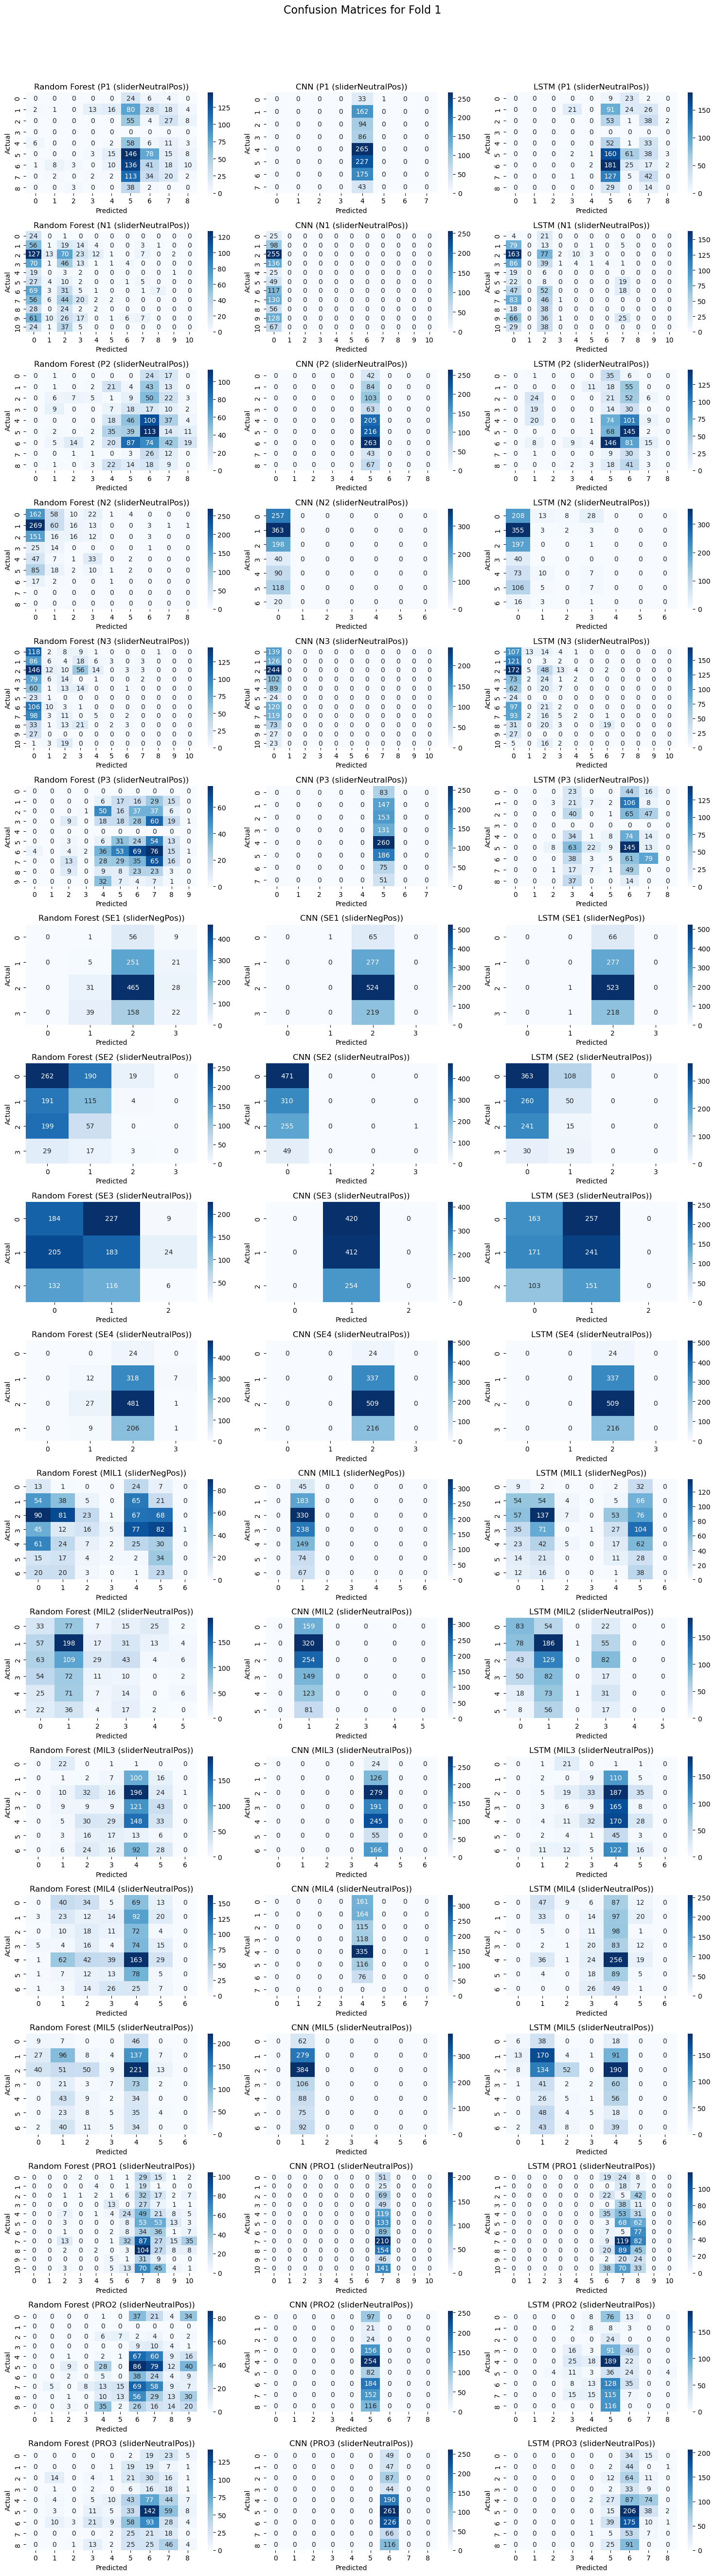

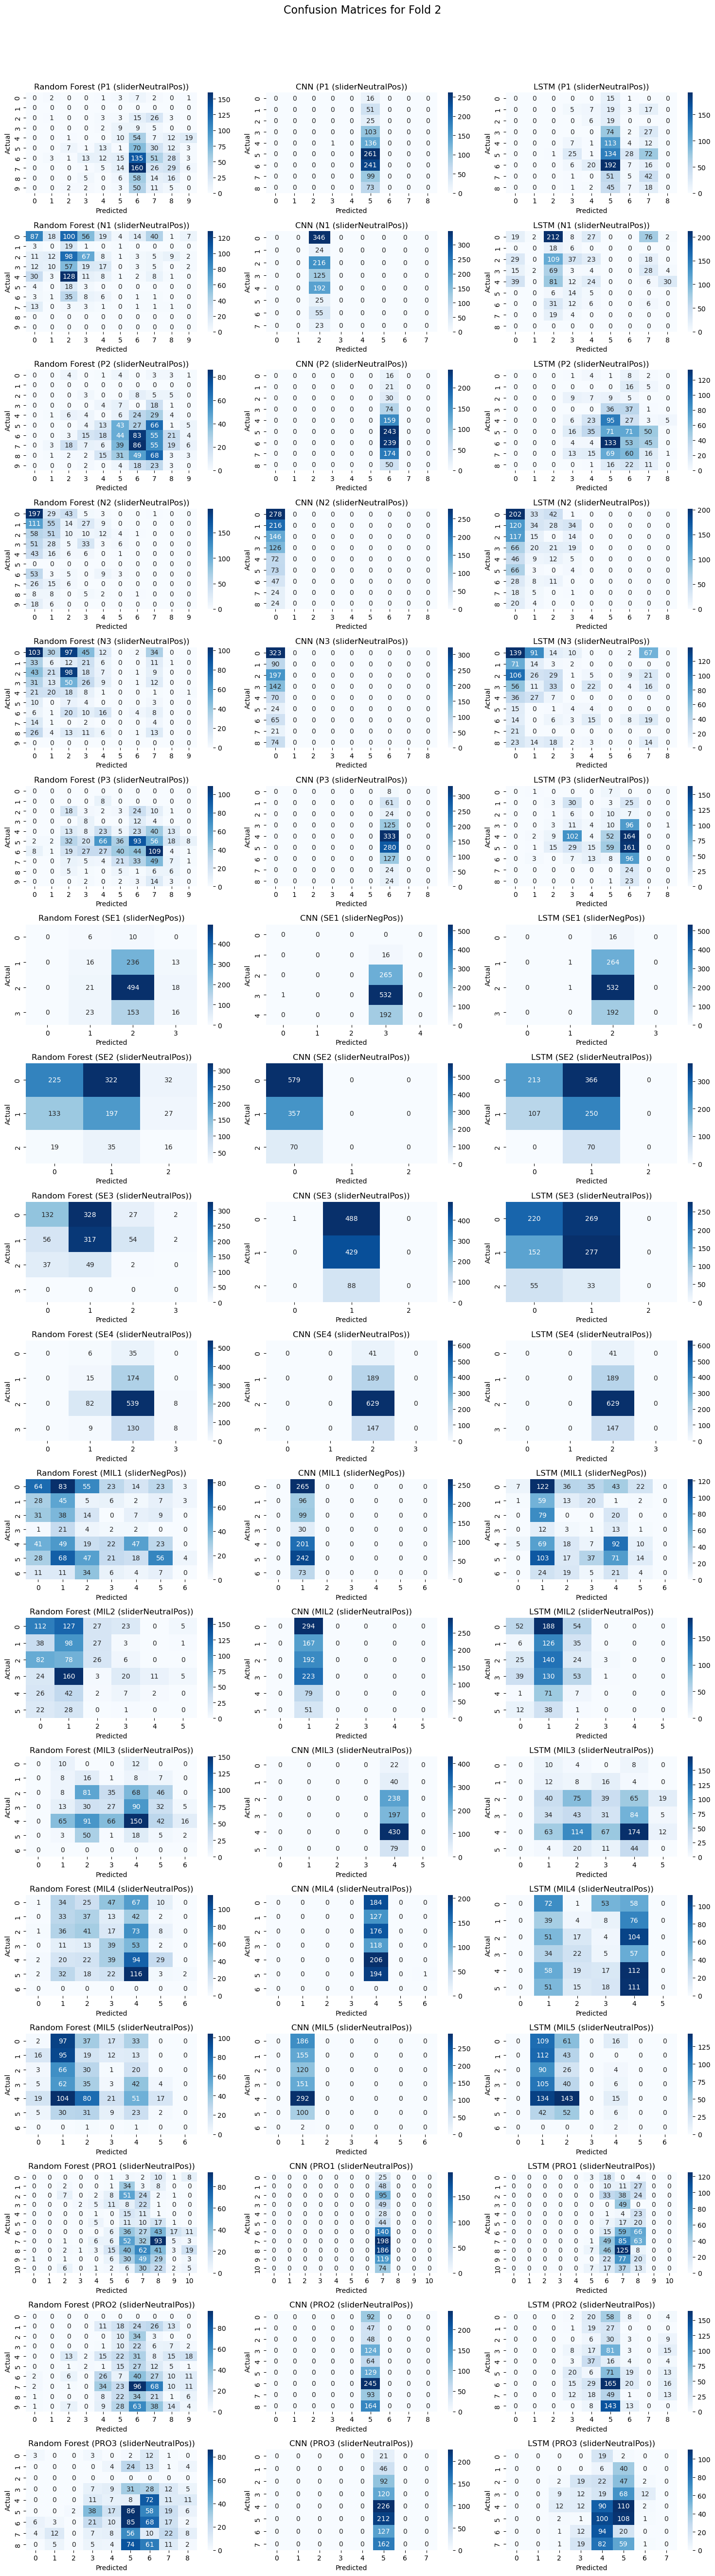

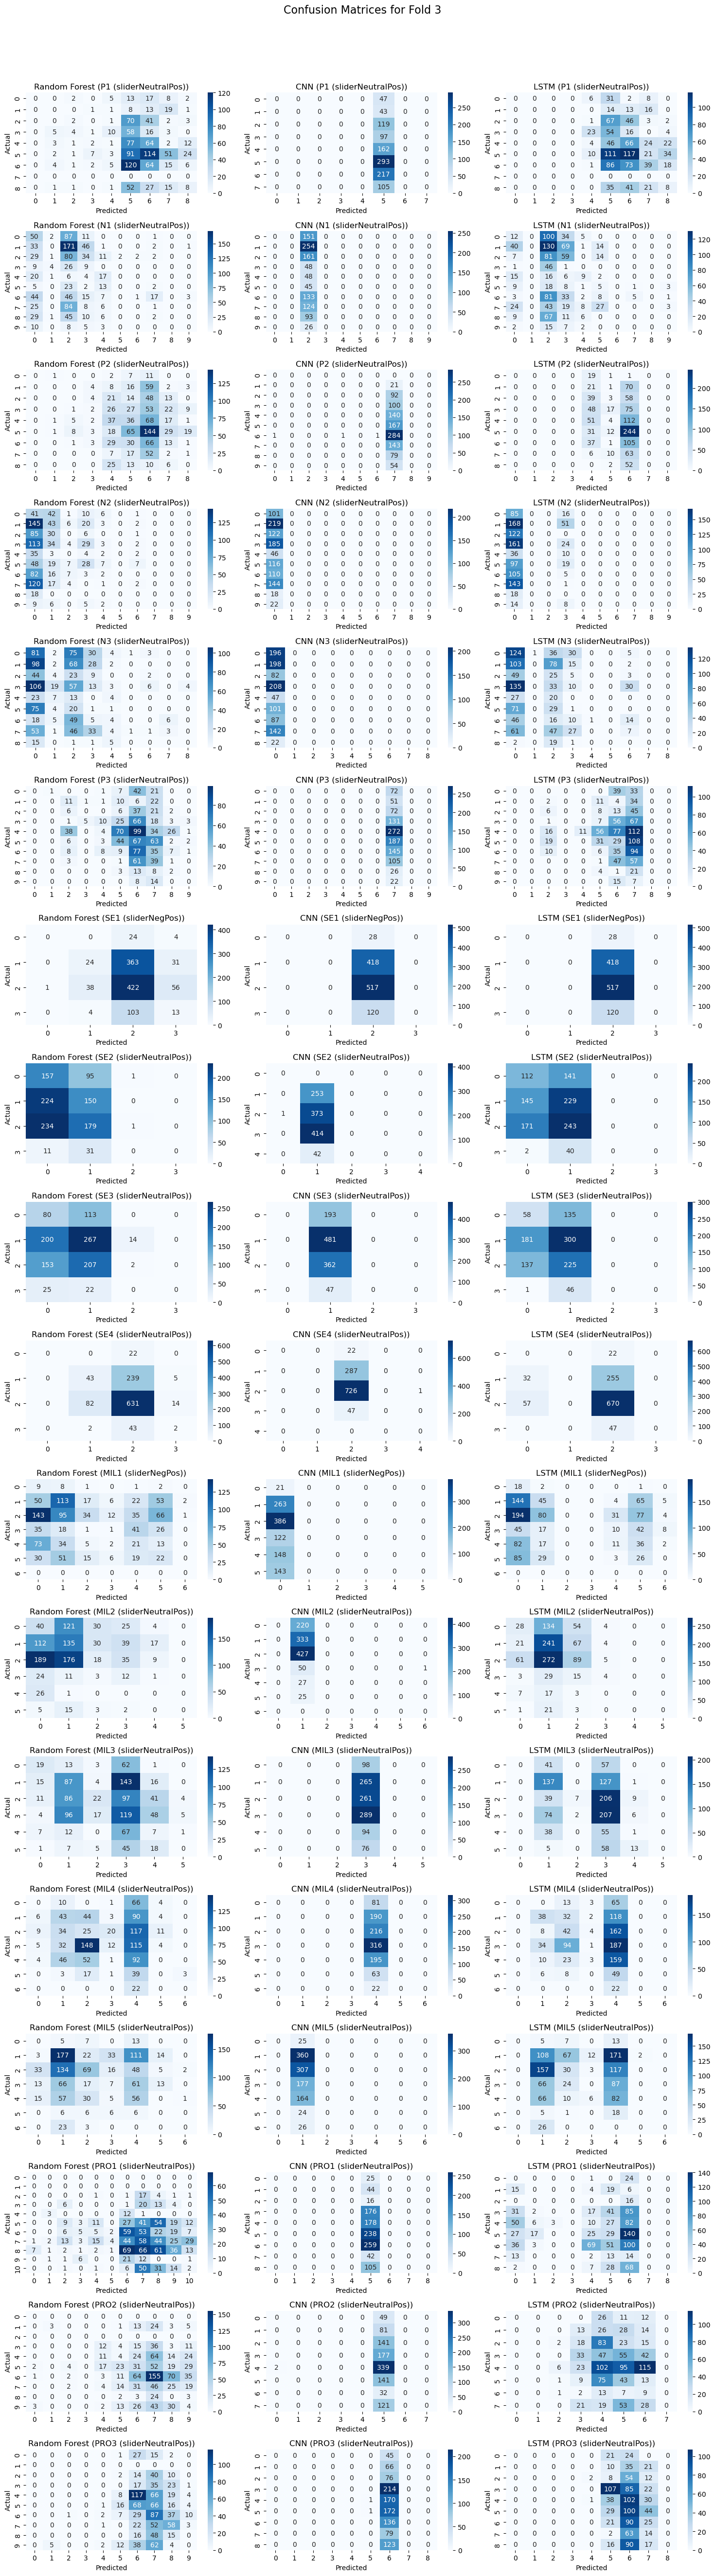

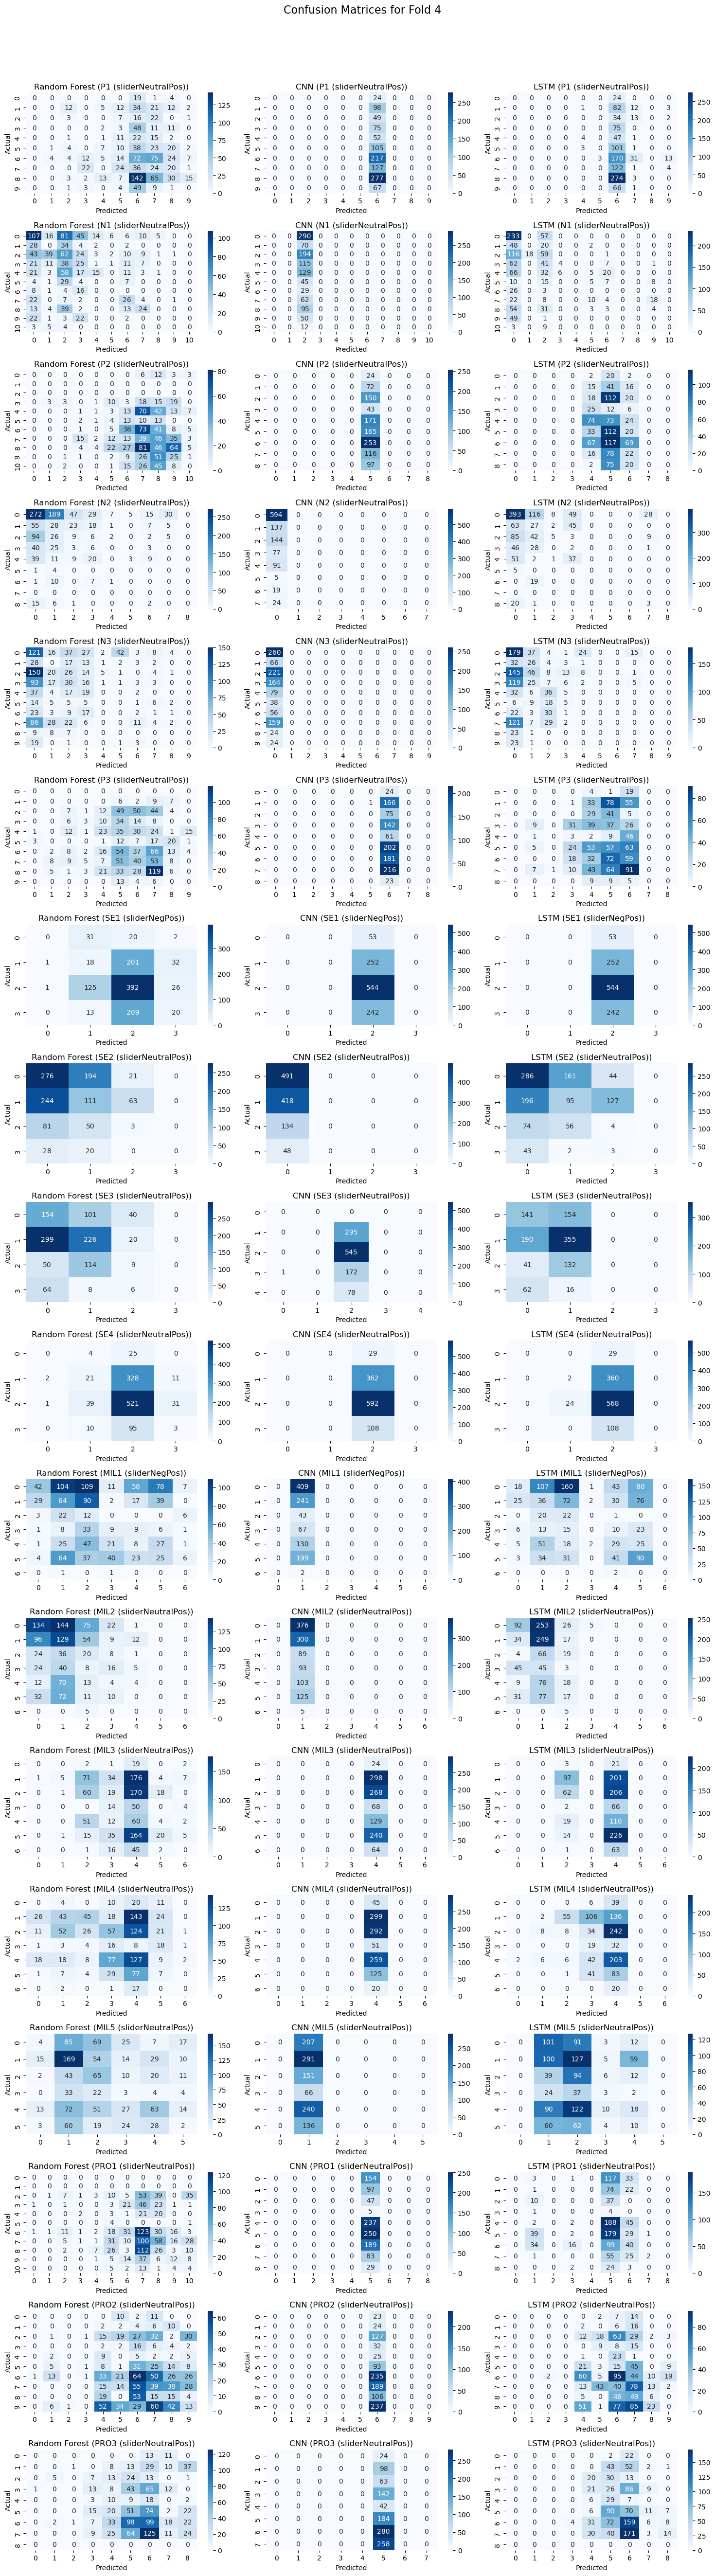

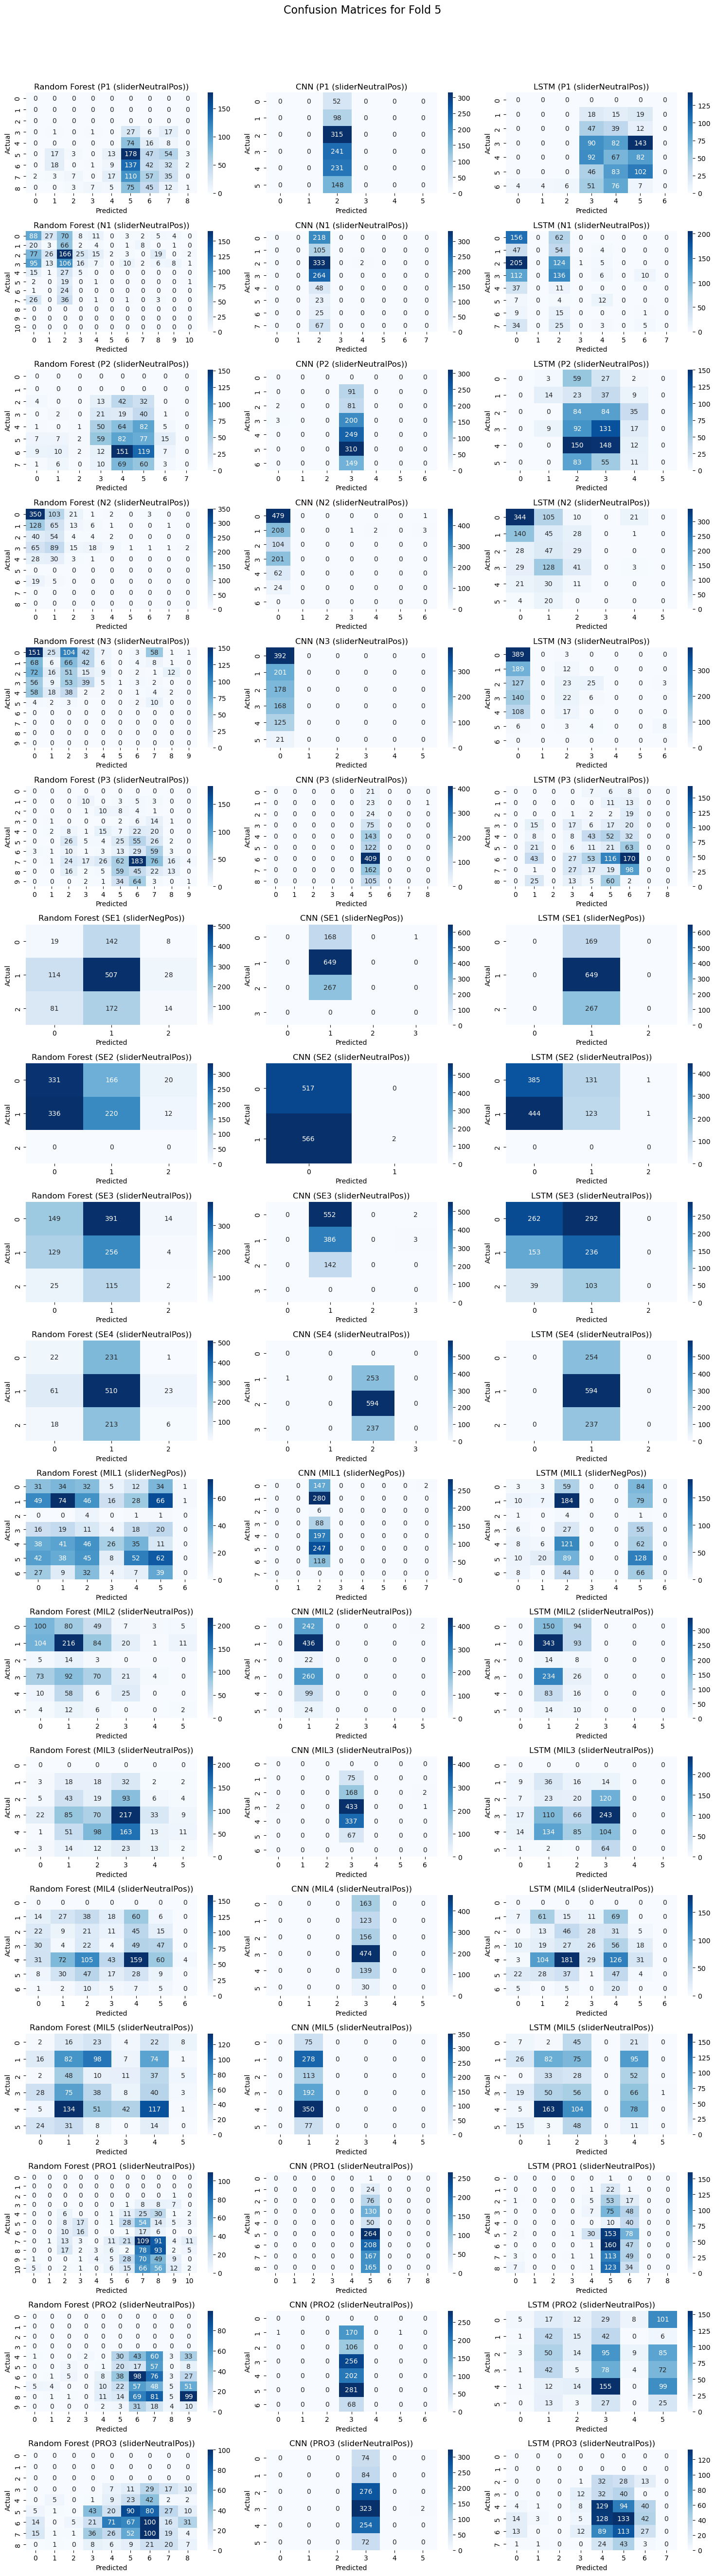

In [8]:
import seaborn as sns
def plot_multi_conf_matrices(conf_matrices, labels, models, fold_count):
    """
    Plots confusion matrices for each label and model across all folds.
    - Rows: Labels
    - Columns: Models
    """
    for fold in range(fold_count):
        fig, axes = plt.subplots(len(labels), len(models), figsize=(15, 3 * len(labels)))
        fig.suptitle(f"Confusion Matrices for Fold {fold + 1}", fontsize=16)

        for i, label in enumerate(labels):
            for j, model in enumerate(models):
                cm = conf_matrices[label][model][fold]  # Get confusion matrix for fold
                ax = axes[i, j] if len(labels) > 1 else axes[j]  # Handle single-label case

                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
                ax.set_xlabel("Predicted")
                ax.set_ylabel("Actual")
                ax.set_title(f"{model} ({label})")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Plot all confusion matrices
models = ["Random Forest", "CNN", "LSTM"]
plot_multi_conf_matrices(conf_matrices, label_columns, models, len(folds))


In [10]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re  # For removing text in parentheses

# Create a directory to save confusion matrices if it doesn't exist
output_dir = "confusion_matrices"
os.makedirs(output_dir, exist_ok=True)

for label, models in merged_conf_matrices.items():
    # 🔹 Remove parentheses and their content from the label
    clean_label = re.sub(r"\(.*?\)", "", label).strip()  # Removes "(...)" and trims spaces

    for model, cm in models.items():
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")

        # 🔹 Format title without redundant text
        title = f"{clean_label} - {model}"
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

        # 🔹 Save the plot instead of displaying
        filename = f"{clean_label}_{model}.png".replace(" ", "_")  # Replace spaces with underscores
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, bbox_inches="tight", dpi=300)  # Save as high-quality image
        plt.close()  # Close figure to free memory

print(f"✅ Confusion matrix plots saved in '{output_dir}' folder.")


✅ Confusion matrix plots saved in 'confusion_matrices' folder.


In [5]:
import numpy as np

def get_max_label_count(conf_matrices):
    """Find the largest class count across all folds and labels."""
    max_classes = 0
    for label in conf_matrices.keys():
        for model in conf_matrices[label].keys():
            for cm in conf_matrices[label][model]:
                max_classes = max(max_classes, cm.shape[0])  # Take max size
    return max_classes

max_classes = get_max_label_count(conf_matrices)
print(f"Max class count: {max_classes}")


Max class count: 11


In [6]:
def pad_conf_matrix(cm, max_classes):
    """
    Pad a confusion matrix with zeros to ensure it has a uniform size.
    """
    padded_cm = np.zeros((max_classes, max_classes))  # Create an empty matrix
    min_dim = cm.shape[0]  # Original size
    padded_cm[:min_dim, :min_dim] = cm  # Copy original values
    return padded_cm


In [7]:
def compute_average_cm(conf_matrices, labels, models, max_classes):
    avg_matrices = {}

    for label in labels:
        avg_matrices[label] = {}
        for model in models:
            # Pad each confusion matrix before averaging
            padded_matrices = [pad_conf_matrix(cm, max_classes) for cm in conf_matrices[label][model]]
            avg_cm = np.mean(padded_matrices, axis=0)  # Compute mean
            avg_matrices[label][model] = avg_cm

    return avg_matrices

# Compute and store averaged confusion matrices
avg_conf_matrices = compute_average_cm(conf_matrices, label_columns, models, max_classes)


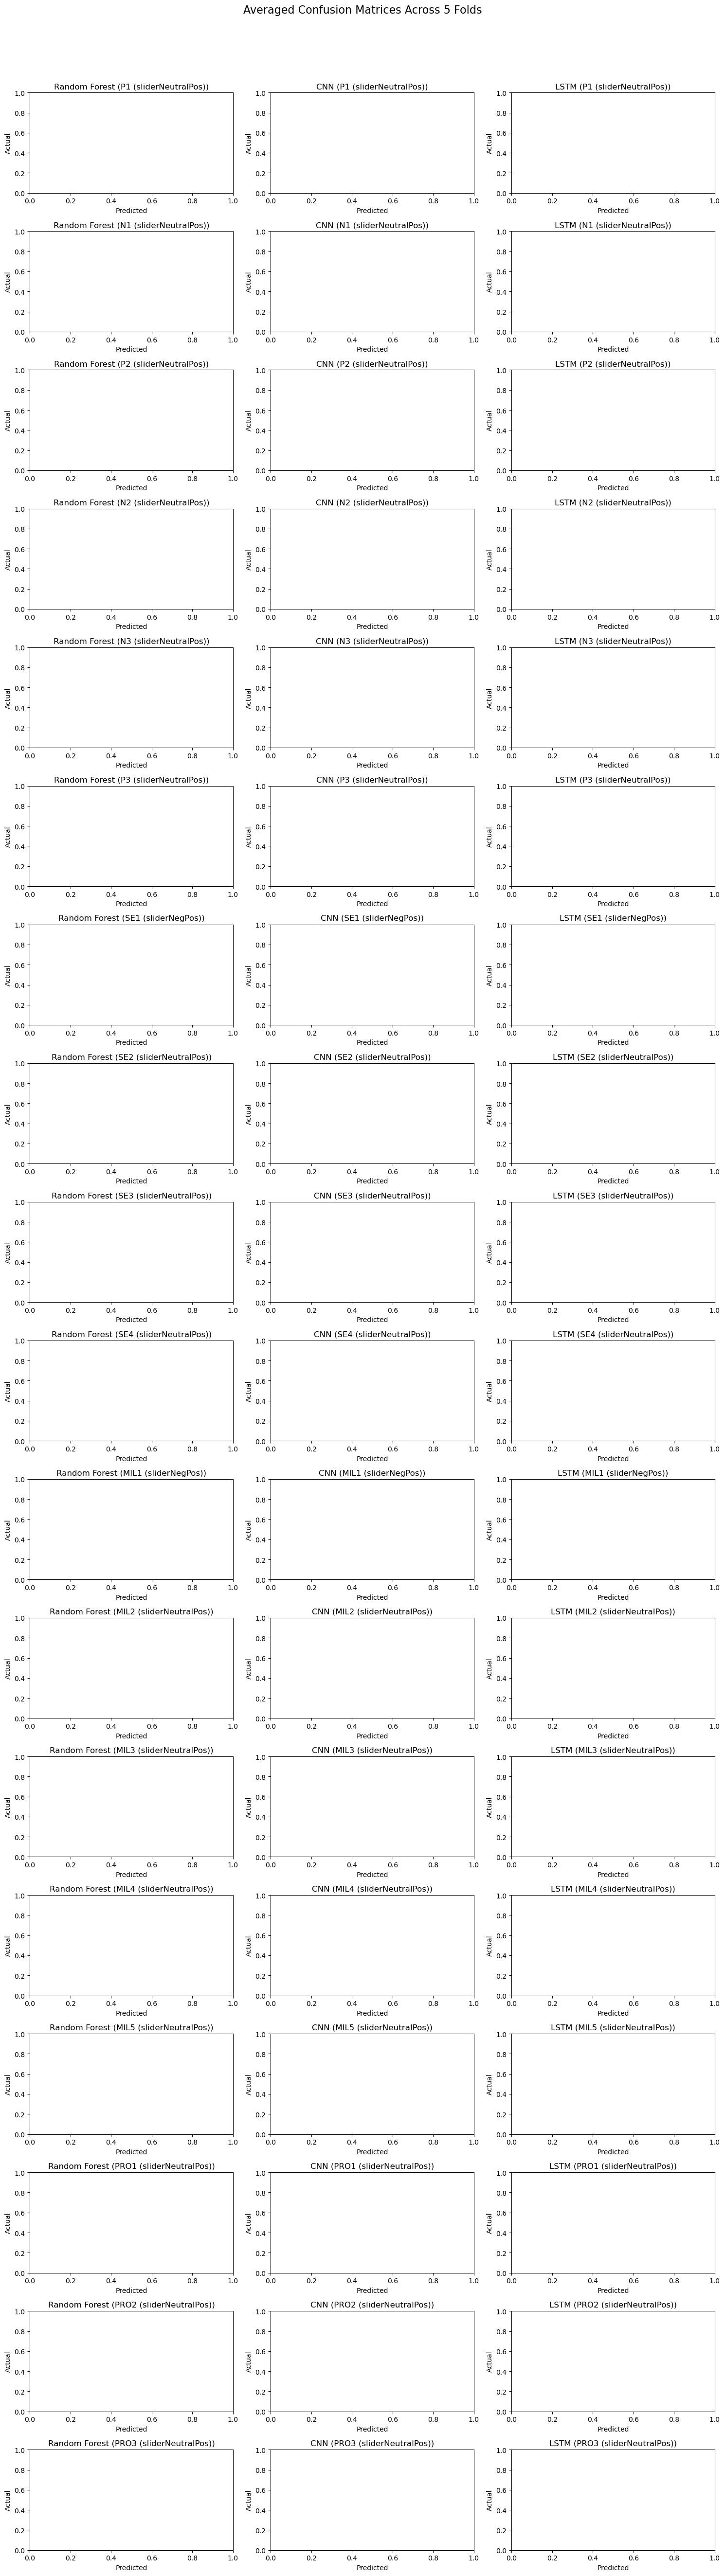

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_avg_conf_matrices(avg_conf_matrices, labels, models):
    fig, axes = plt.subplots(len(labels), len(models), figsize=(15, 3 * len(labels)))
    fig.suptitle("Averaged Confusion Matrices Across 5 Folds", fontsize=16)

    for i, label in enumerate(labels):
        for j, model in enumerate(models):
            cm = avg_conf_matrices[label][model]
            ax = axes[i, j] if len(labels) > 1 else axes[j]  # Handle single-label case

            # sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=ax)
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
            ax.set_title(f"{model} ({label})")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Show fixed averaged confusion matrices
plot_avg_conf_matrices(avg_conf_matrices, label_columns, models)


In [10]:
import numpy as np
import os
import pandas as pd

# Define directory for saving matrices
save_dir = "saved_conf_matrices"
os.makedirs(save_dir, exist_ok=True)

# Save each confusion matrix for every fold, label, and model
for label in conf_matrices.keys():
    for model in conf_matrices[label].keys():
        for fold_idx, cm in enumerate(conf_matrices[label][model]):
            # Create a filename: fold_label_model.csv
            filename = f"{save_dir}/fold_{fold_idx+1}_{label}_{model}.csv"
            np.savetxt(filename, cm, delimiter=",", fmt="%d")
            print(f"Saved: {filename}")


Saved: saved_conf_matrices/fold_1_P1 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/fold_2_P1 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/fold_3_P1 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/fold_4_P1 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/fold_5_P1 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/fold_1_P1 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/fold_2_P1 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/fold_3_P1 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/fold_4_P1 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/fold_5_P1 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/fold_1_P1 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/fold_2_P1 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/fold_3_P1 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/fold_4_P1 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/fold_5_P1 (sliderNeutra

In [11]:
# Save averaged confusion matrices
for label in avg_conf_matrices.keys():
    for model in avg_conf_matrices[label].keys():
        filename = f"{save_dir}/average_{label}_{model}.csv"
        np.savetxt(filename, avg_conf_matrices[label][model], delimiter=",", fmt="%.2f")
        print(f"Saved: {filename}")


Saved: saved_conf_matrices/average_P1 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/average_P1 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/average_P1 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/average_N1 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/average_N1 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/average_N1 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/average_P2 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/average_P2 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/average_P2 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/average_N2 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/average_N2 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/average_N2 (sliderNeutralPos)_LSTM.csv
Saved: saved_conf_matrices/average_N3 (sliderNeutralPos)_Random Forest.csv
Saved: saved_conf_matrices/average_N3 (sliderNeutralPos)_CNN.csv
Saved: saved_conf_matrices/average_N

In [12]:
import shutil
from IPython.display import FileLink

# Create a zip file of all saved confusion matrices
shutil.make_archive("conf_matrices", "zip", save_dir)

# Provide download link
FileLink("conf_matrices.zip")


/home/jovyan/PPSMLDB/2024 BioMeans/Combine_Feature_Label/0226Data_process_Filter_kfold/conf_matrices.zip